### Отримання метеорологічних даних від NOAA

Завантажуємо CSV файл з сайту https://www.ncdc.noaa.gov/cag/

Посилання на файл:
https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/city/time-series/USH00305801/tavg/1/1/1895-2022.csv?base_prd=true&begbaseyear=1991&endbaseyear=2020

В файлі знаходяться дані січневих температур Нью-Йорка починаючи з 1895 року

Прибираємо зайві стовпці і рядки, називаємо стовпці відповідними іменами

In [10]:
import pandas as pd

temperatures = pd.read_csv("https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/city/time-series/USH00305801/tavg/1/1/1895-2022.csv?base_prd=true&begbaseyear=1991&endbaseyear=2020",
                           usecols=[0, 1, 2],
                            names=["Date", "Temperature", "Anomaly"],
                            skiprows=5,
                           )
temperatures.head()


,Date,Temperature,Anomaly
0,189501,28.4,-5.1
1,189601,28.0,-5.5
2,189701,28.8,-4.7
3,189801,33.4,-0.1
4,189901,29.3,-4.2


### Обробка даних

Оскільки дати знаходяться в форматі YYYYMM, то приберемо з них місяць, оскільки відомо, що вони всі січні

In [11]:
temperatures.Date = temperatures.Date.floordiv(100)
temperatures.head()

,Date,Temperature,Anomaly
0,1895,28.4,-5.1
1,1896,28.0,-5.5
2,1897,28.8,-4.7
3,1898,33.4,-0.1
4,1899,29.3,-4.2


### Прогнози на 2019-2022 роки

Спрогнозуємо температуру на 2019-2022 роки за допомогою регресійної прямої, для цього використаємо бібліотеку scipy, яка містить функцію stats.linregress:

In [12]:
from scipy import stats

linear_regression = stats.linregress(temperatures.Date, temperatures.Temperature)

Цей об'єкт містить в собі дві змінні: slope та intercept, які відповідають коефіцієнтам прямої m та b в рівнянні прямої

$$ y=mx+b $$

Визначимо функцію, яка буде приймати рік і повертати прогнозовану температуру

In [13]:
def predict(year):
    return linear_regression.slope * year + linear_regression.intercept

# Predicted temperatures for the 2019-2022
print({year: predict(year) for year in range(2019, 2023)})

{2019: 33.09507702343893, 2020: 33.12159689159495, 2021: 33.14811675975096, 2022: 33.17463662790698}


#### Припущення за 1890 рік

In [14]:
print({1890: predict(1890)})

{1890: 29.674014031312943}


### Візуалізація даних

Побудуємо регресійну пряму, що представляє графік зміни обраних показників за період 1895-2022 років.

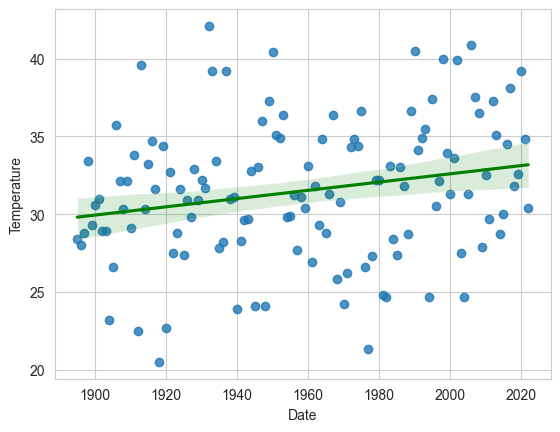

In [15]:
import seaborn as sns

sns.set_style("whitegrid")

plot = sns.regplot(x="Date", y="Temperature", data=temperatures, line_kws={"color": "green"})

plot.figure.canvas.draw()

Нахил регресійної прямої показує, що протягом останніх 125 років середня температура зростала.

### Масштабування

Відобразимо дані в іншому масштабі, щоб краще бачити зміни температури і нахил прямої

(0.0, 60.0)

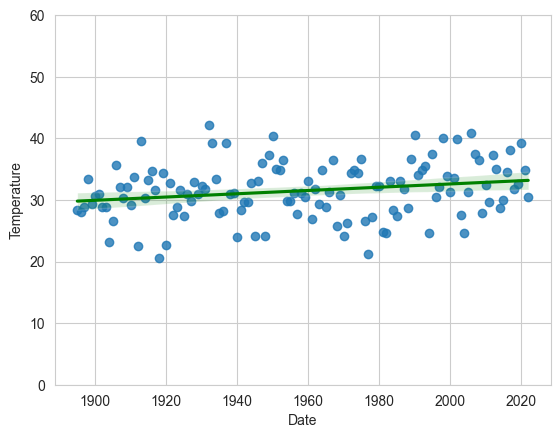

In [16]:
plot = sns.regplot(x="Date", y="Temperature", data=temperatures, line_kws={"color": "green"})
plot.set_ylim(0, 60)

### Перевірка прогнозу

Порівняємо дані, отримані за формулою регресійної прямої, з реальними даними

In [23]:
print("Predicted temperatures:", pd.Series({year: predict(year) for year in range(2019, 2023)}), sep="\n")

print("\nActual temperatures:", temperatures[temperatures["Date"] >= 2019].loc[:, ["Date", "Temperature"]], sep="\n")

Predicted temperatures:
2019    33.095077
2020    33.121597
2021    33.148117
2022    33.174637
dtype: float64

Actual temperatures:
     Date  Temperature
124  2019         32.6
125  2020         39.2
126  2021         34.8
127  2022         30.4


Як бачимо, прогнози не сильно відрізняються від реальних даних. Якщо ми знайдемо стандартне відхилення:

In [24]:
print("Std variance:", temperatures.Temperature.std())

Std variance: 4.476824618121345


То бачимо, що значення лежать в проміжках (або близько до проміжку) +- 4.5 градусів